# tf.data: Build TensorFlow input pipelines
https://www.tensorflow.org/guide/data?hl=ja

In [180]:
!nvidia-smi

Thu Feb 27 06:06:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:01:00.0 Off |                  N/A |
| 27%   34C    P8     9W / 250W |  10603MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:02:00.0 Off |                  N/A |
| 27%   33C    P8     6W / 250W |    247MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [6]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [8]:
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


In [9]:
it = iter(dataset)
print(next(it).numpy())

8


In [10]:
dataset.reduce(0, lambda state, value: state + value).numpy()

22

In [11]:
tf.random.uniform([4, 10])

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[0.5823171 , 0.30376983, 0.2948773 , 0.30190754, 0.78946984,
        0.93167615, 0.27930486, 0.2819909 , 0.43076646, 0.15363622],
       [0.6822834 , 0.79755247, 0.16364765, 0.73253715, 0.5487355 ,
        0.8001331 , 0.6082133 , 0.8106586 , 0.16416967, 0.77634406],
       [0.02369571, 0.35190213, 0.16820931, 0.6410842 , 0.04191387,
        0.32144356, 0.3191409 , 0.00921774, 0.92771447, 0.8370395 ],
       [0.30830848, 0.43923235, 0.31779516, 0.49033606, 0.03648806,
        0.7528397 , 0.09013987, 0.8025491 , 0.27008998, 0.28283584]],
      dtype=float32)>

## Dataset.from_tensor_slices()

- Dataset.from_tensor_slices() は入力テンソルの1次元目がデータ数になる
- 残りの次元が返されるデータのshapeになる
- 返されるデータの次元を知りたい場合は tensor.element_spec
- ()はスカラーを意味する
- Datasetをマージしたい時は Dataset.zip() が使える。ただし、データ数があってないとできない
- Datasetではなく、ndarrayをマージする時は from_tensor_slices() でタプルにすればいい
- 適当な入力が作りたい時は tf.random.uniform([4, 100])

In [12]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [13]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]),
     tf.random.uniform([4, 100], maxval=100, dtype=tf.int32))
)

In [14]:
dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [15]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [16]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32)
)
dataset1

<TensorSliceDataset shapes: (10,), types: tf.int32>

In [17]:
for z in dataset1:
    print(z.numpy())

[1 9 8 4 2 5 6 1 9 1]
[8 3 8 2 1 5 3 6 5 2]
[7 7 6 5 2 3 6 1 7 4]
[8 7 7 2 2 3 6 5 9 6]


In [18]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]),
     tf.random.uniform([4, 100], maxval=100, dtype=tf.int32))
)
dataset2

<TensorSliceDataset shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [19]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3

<ZipDataset shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [20]:
for a, (b, c) in dataset3:
    print(a.shape, b.shape, c.shape)

(10,) () (100,)
(10,) () (100,)
(10,) () (100,)
(10,) () (100,)


## メモリ内のndarrayからDatasetを作る

- Dataset.from_tensor_slices() が最適
- ndarrayがtf.Tensorに変換される

In [21]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [22]:
len(train), train[0].shape, train[1].shape, type(train[0])

(2, (60000, 28, 28), (60000,), numpy.ndarray)

In [23]:
images, labels = train
images = images / 255

In [24]:
# 0次元目がデータ数として扱われる
# imagesもlabelsも0次元目が60000で同じサイズなのに注意
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

## GeneratorからDatasetを作る

- Dataset.from_generator()
- repeat() を使うと無限に生成する
- batch() で複数のデータをまとめられる
- take() を指定すると取得が制限できる
- output_shapeはできるだけ指定する、出力サイズがわからない、可変の時はNoneとする
- padded_batch() でバッチ単位でpaddingができる、padded_shapesは可変の時はNoneとすると最大長でpadding

In [25]:
def count(stop):
    i = 0
    while i < stop:
        yield i
        i += 1

In [26]:
for n in count(5):
    print(n)

0
1
2
3
4


In [27]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes=())

In [28]:
for n in ds_counter:
    print(n)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(20, shape=(), dtype=int32)
tf.Tensor(21, shape=(), dtype=int32)
tf.Tensor(22, shape=(), dtype=int32)
tf.Tensor(23, shape=(), dtype=int32)
tf.Tensor(24, shape=(), dtype=int32)


In [29]:
for count_batch in ds_counter.repeat().batch(10).take(10):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


In [30]:
# 出力サイズが可変の系列を返すgenerator
def gen_series():
    i = 0
    while True:
        size = np.random.randint(0, 10)
        yield i, np.random.normal(size=(size, ))
        i += 1

In [31]:
for i, series in gen_series():
    print(i, ':', str(series))
    if i > 5:
        break

0 : [-0.13636479 -1.25519084 -3.10380528  0.8022715  -2.30499733 -2.9779837
 -1.7601751   0.52485298  0.21989364]
1 : [ 0.36595531  1.93990132  1.57994552 -1.10814247 -0.74975942]
2 : []
3 : [ 0.13523206  3.22366438  0.22527852 -0.39792645 -1.30973927  0.16560829
  1.08913119 -0.03249859 -0.09315613]
4 : [0.34156623 0.80928813]
5 : [-0.35441405  0.3377346  -0.15699354  1.42981465 -0.79110377  1.91053789
  0.03426807]
6 : [ 0.16561727 -1.2935074   0.35978581 -0.79819554 -0.92978016 -0.22362973
 -1.46773799  1.63232314]


In [32]:
ds_series = tf.data.Dataset.from_generator(
    gen_series,
    output_types=(tf.int32, tf.float32),
    output_shapes=((), (None, )))
ds_series

<FlatMapDataset shapes: ((), (None,)), types: (tf.int32, tf.float32)>

In [33]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10, padded_shapes=((), (None, )))
ids, sequence_batch = next(iter(ds_series_batch))
print(ids.shape)
print(sequence_batch.shape)

(10,)
(10, 8)


In [34]:
print(sequence_batch.numpy())

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.6893477e+00 -1.0703098e+00  1.2316743e+00 -7.8907430e-01
   4.8051316e-01 -1.7831041e-01  1.0625595e+00  0.0000000e+00]
 [ 4.9014375e-01  8.4993142e-01  4.7716224e-01 -4.6194640e-01
  -1.9587033e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 3.9407137e-01 -7.3681027e-01 -1.8738458e+00 -1.3484717e-02
  -1.8493785e+00  2.4907112e-01 -7.9216349e-01  0.0000000e+00]
 [ 4.5469400e-01 -9.2915034e-01  6.7814732e-01 -1.2471077e+00
   4.2199367e-01 -7.2679061e-01 -1.3780706e+00  1.2675012e-03]
 [ 6.2312776e-01  4.2411977e-01 -1.0572541e+00 -8.7057263e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.2746660e+00  1.4433522e+00 -1.5729892e+00  1.1084211e+00
  -1.0231497e+00 -2.6219788e-01 -1.2915394e+00  0.0000000e+00]
 [-1.4109733e+00 -3.6311680e-01 -1.2182708e+00  1.0093077e-01
  -6.1111176e-01 -4.8463607e-01  0.0000000e+00  0.0000000e+00]


## ImageDataGenerator

- ImageDataGenerator.flow_from_directory() はgeneratorを返すのでDatasetでwarppingできる
- 公式の通りにやるとiterでInvalidArgumentErrorが起きる
- https://github.com/tensorflow/tensorflow/issues/33133

```python
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
gen = img_gen.flow_from_directory(flowers, batch_size=64)

ds = tf.data.Dataset.from_generator(
    lambda: gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 256, 256, 3], [None, 5])
)
```

In [35]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [36]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [48]:
images, labels = next(img_gen.flow_from_directory(flowers, batch_size=32))

Found 3670 images belonging to 5 classes.


In [49]:
images.dtype, images.shape

(dtype('float32'), (32, 256, 256, 3))

In [50]:
labels.dtype, labels.shape

(dtype('float32'), (32, 5))

In [74]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
gen = img_gen.flow_from_directory(flowers, batch_size=64)

ds = tf.data.Dataset.from_generator(
    lambda: gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 256, 256, 3], [None, 5])
)

Found 3670 images belonging to 5 classes.


In [75]:
for x, y in ds:
    print(x.shape, y.shape)
    break

(64, 256, 256, 3) (64, 5)


## TFRecord

- メモリに収まらないデータも使える
- バイナリフォーマット
- .tfrecからDatasetを作るにはTFRecordDataset

In [76]:
fsns_test_file = tf.keras.utils.get_file(
    "fsns.tfrec",
    "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7905280/7904079 [==============================] - 1s 0us/step


In [77]:
fsns_test_file

'/root/.keras/datasets/fsns.tfrec'

In [78]:
dataset = tf.data.TFRecordDataset(filenames=[fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [81]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

In [87]:
parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

## Text Dataset

- tf.data.TextLineDatasetが使える

In [89]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name) for file_name in file_names
]

811008/807992 [==============================] - 0s 0us/step


In [90]:
file_paths

['/root/.keras/datasets/cowper.txt',
 '/root/.keras/datasets/derby.txt',
 '/root/.keras/datasets/butler.txt']

In [91]:
dataset = tf.data.TextLineDataset(file_paths)

In [93]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;", shape=(), dtype=string)
tf.Tensor(b'His wrath pernicious, who ten thousand woes', shape=(), dtype=string)
tf.Tensor(b"Caused to Achaia's host, sent many a soul", shape=(), dtype=string)
tf.Tensor(b'Illustrious into Ades premature,', shape=(), dtype=string)
tf.Tensor(b'And Heroes gave (so stood the will of Jove)', shape=(), dtype=string)


## Simple batching

- batchを作るにはTensorが同じサイズである必要がある
- batch() でミニバッチが構成できる
- デフォルトでは最後のバッチの大きさがわからないためサイズはNoneになる
- drop_remainder=Trueを指定するとサイズが固定になるので表示される

In [97]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)

In [99]:
inc_dataset

<RangeDataset shapes: (), types: tf.int64>

In [100]:
dec_dataset

<RangeDataset shapes: (), types: tf.int64>

In [101]:
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
dataset

<ZipDataset shapes: ((), ()), types: (tf.int64, tf.int64)>

In [112]:
batched_dataset = dataset.batch(4)
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

In [108]:
for x, y in batched_dataset.take(3):
    print(x.numpy(), y.numpy())

[0 1 2 3] [ 0 -1 -2 -3]
[4 5 6 7] [-4 -5 -6 -7]
[ 8  9 10 11] [ -8  -9 -10 -11]


In [111]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

## Batching tensors with padding

- batch() はバッチの構成要素が同じサイズである必要がある
- 系列データのように長さが固定でない場合は Dataset.padded_batch() を使う
- padded_shapesには直前のdatasetのshapesを書けばOK
- paddingしたい次元をNoneにすればOK
- 0以外のpaddingも可能

In [124]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset

<MapDataset shapes: (None,), types: tf.int64>

In [125]:
dataset = dataset.padded_batch(4, padded_shapes=(None, ))

In [126]:
for batch in dataset.take(2):
    print(batch)

tf.Tensor(
[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]], shape=(4, 3), dtype=int64)
tf.Tensor(
[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]], shape=(4, 7), dtype=int64)


In [176]:
a = np.ones(shape=(3, 5))
b = np.ones(shape=(1, 5))
c = np.ones(shape=(4, 5))
d = np.ones(shape=(7, 5))
data = [a, b, c, d]
data

[array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])]

In [177]:
dataset = tf.data.Dataset.from_generator(lambda: data, output_types=data[0].dtype, output_shapes=([None, 5]))
dataset

<FlatMapDataset shapes: (None, 5), types: tf.float64>

In [178]:
dataset = dataset.padded_batch(2, padded_shapes=(None, 5))

In [179]:
for x in dataset:
    print(x.numpy())

[[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
[[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]


### Consuming sets of files

- ファイルのDatasetの作り方
- Dataset.list_files()

In [210]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [212]:
flowers_root = pathlib.Path(flowers_root)
flowers_root

PosixPath('/root/.keras/datasets/flower_photos')

In [213]:
for item in flowers_root.glob('*'):
    print(item.name)

roses
tulips
daisy
dandelion
sunflowers


In [214]:
list_ds = tf.data.Dataset.list_files(str(flowers_root / '*/*'))

In [215]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/13471563274_471fc1db33_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/19784656639_cd7f0a4a26_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/6994933428_307b092ce7_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/9610371852_179e7781ce.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16711791713_e54bc9c1af_n.jpg'


In [217]:
def process_path(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    return tf.io.read_file(file_path), label

In [219]:
labeled_ds = list_ds.map(process_path)
labeled_ds

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [220]:
for image_raw, label_text in labeled_ds.take(1):
    print(repr(image_raw.numpy()[:30]))
    print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x0cXICC_PR'
b'sunflowers'


## Training workflows

### Repeat

- epoch単位で同じデータをなんどもなめる仕組みとしてDataset.repeat()がある
- repeat().batch()とbatch().repeat()は違うので要注意
- epochのループを回す場合はrepeat()を使わない！

In [181]:
titanic_file = tf.keras.utils.get_file(
    'train.csv',
    'https://storage.googleapis.com/tf-datasets/titanic/train.csv')

32768/30874 [===============================] - 0s 0us/step


In [182]:
titanic_file

'/root/.keras/datasets/train.csv'

In [183]:
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [190]:
for line in titanic_lines:
    print(line.numpy())
    break

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'


In [191]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')

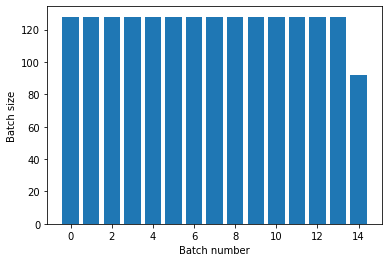

In [198]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

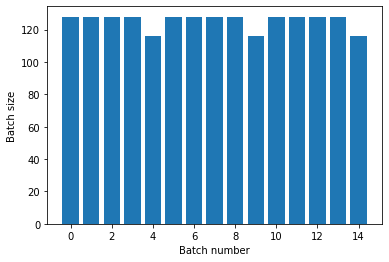

In [199]:
titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(titanic_batches)

In [200]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in dataset:
        print(batch.shape)
    print('End of epoch: ', epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### Shuffle

- buffer_sizeが小さいと十分shuffleされない
- 最初のバッチにbuffer_size + batchを超えるindexが含まれないことからわかる

In [201]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

In [206]:
dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=30)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

In [207]:
for i, x in dataset:
    print(i, x)
    break

tf.Tensor([ 2 22  8  0 25  7 30 20 21  5 32 36  9  6 10 40 14 13 47  3], shape=(20,), dtype=int64) tf.Tensor(
[b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
 b'1,female,28.0,0,0,7.8792,Third,unknown,Queenstown,y'
 b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
 b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
 b'1,female,28.0,1,0,146.5208,First,B,Cherbourg,n'
 b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
 b'1,male,28.0,0,0,7.2292,Third,unknown,Cherbourg,y'
 b'0,male,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
 b'0,male,19.0,3,2,263.0,First,C,Southampton,n'
 b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
 b'0,female,40.0,1,0,9.475,Third,unknown,Southampton,n'
 b'0,male,28.0,0,0,8.05,Third,unknown,Southampton,y'
 b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
 b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
 b'0,male,20.0,0,0,8.05,Third,unknown,Southampton,y'
 b'0,male,7.0,4,1,39.6875,Third,unknown,Southampton,n'
 b'1,male,28

### Preprocessing data

- Dataset.map(f)で前処理ができる
- TensorFlowではないnumpyやscipyの前処理をしたい時は tf.py_function() が使える
- TensorFlowにも tensorflow_addons にいくつかある

In [222]:
list_ds = tf.data.Dataset.list_files(str(flowers_root / '*/*'))
list_ds

<ShuffleDataset shapes: (), types: tf.string>

In [223]:
def parse_image(filename):
    parts = tf.strings.split(filename, '/')
    label = parts[-2]
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

In [224]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

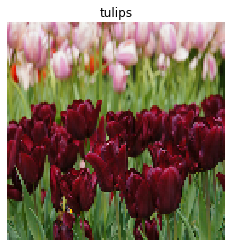

In [227]:
def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image, label)

In [230]:
images_ds = list_ds.map(parse_image)
images_ds

<MapDataset shapes: ((128, 128, None), ()), types: (tf.float32, tf.string)>

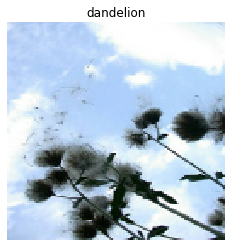

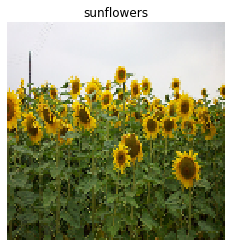

In [231]:
for image, label in images_ds.take(2):
    show(image, label)

In [232]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

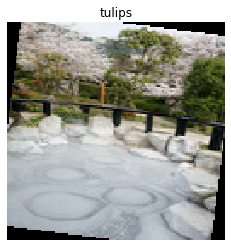

In [233]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [239]:
def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image, ] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

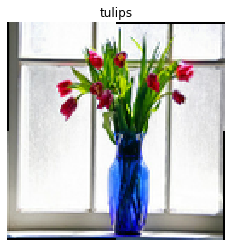

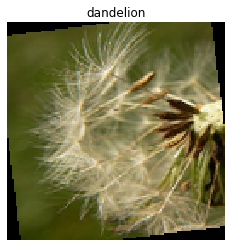

In [240]:
rot_ds = images_ds.map(tf_random_rotate_image)
for image, label in rot_ds.take(2):
    show(image, label)